# Decision Tree Regressor without Transfer

In diesem Notebook wird ein _Decision Tree Regressor_ auf das Zieldatenset angewendet und die Hyperparameter mithilfe einer Grid Search getuned. In diesem Modell findet kein Transfer statt.


# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import re
import tqdm

# Preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import nltk

# Preprocess features
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

# Preprocess targets
from sklearn.preprocessing import MinMaxScaler

#LSTM for regression
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Visulization
import matplotlib.pyplot as plt
from sklearn_evaluation import plot

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-07-02 14:35:22.066071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leamayer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Loading

Zunächst wird das kanadische Youtube-Datenset aus dem Jahr 2012 als das Zieldatenset für dieses Projekt festgelegt. Anschließend werden die textuellen Attribute der Videos als Features und die Views der Videos als Target ausgewählt. 

In [2]:
# Select Target Dataset

target_file = "CAvideos_12.csv"

df_target = pd.read_csv("../Data/processed_data/"+target_file)
df_target = df_target.dropna() # drop Nan columns as there are enough instances and text features are not easily replacable with mean values

df_target = df_target [["channel_title","tags","description","title","views"]]

df_target["views"] = df_target["views"].astype(int)

print(f">>> Created target df ({len(df_target)})")

>>> Created target df (6037)


In [3]:
# Define features and targets

feature_df = df_target [["channel_title","tags","description","title"]]  # Create df for text data 
targets = df_target["views"].to_numpy()  # Target data


## Preprocessing

### Normalize Targets

Die Normalisierung der Zieldaten verbesser die Vergleichbarkeit, Interpretierbarkeit, Konsistenz und Stabilität der Vorhersage. Dafür wird im folgenden der Min-Max Scaler der Sklearn Bibliothek verwendet.

In [4]:
# Normalizing the target with min-max normalization

scaler = MinMaxScaler()
normalized_targets = scaler.fit_transform(targets.reshape(-1, 1)).flatten()

print(f">>> Range from original targets ({targets.min()};{targets.max()}) has been normalized ({normalized_targets.min()};{normalized_targets.max()})")

>>> Range from original targets (1295;137843120) has been normalized (0.0;1.0)


### Apply Stemmer and Remove Stopwords from Text Features

Um Wörter derselben Wortfamilie auf eine gemeinsame Stamm zurückführen, wird im Folgenden ein ***Stemmer*** auf die Features angewendet. Im Gegensatz zu einem Lemmatisierer, der die Wörter auf ihre Grundform reduziert, ist der Stemmer wesentlich schneller, da nur die Wortendungen entfernt werden. Dies kann zu grammatikalisch inkonsistenten Sätzen führen, was aber bei dieser Aufgabe zu vernachlässigen ist.

Des weiteren werden semantisch ***unwichtige Wörter*** (die häufig vorkommen) entfernt. Dabei wird auf die nlkt English-Stopwords-Liste zurückgegriffen. Um noch weitere Youtube-spezifische Stowords zu indentifizieren. Werden für jedes Feature 250 weitere Stopwords mithilfe des Tfidf-Scores identifiziert und zu den nlkt Stopwords hinzugefügt. Dieser Score sagt aus, ob ein Wort über alle Youtubevideos hinweg oft vorkommt und dementsprechend semmantisch unwichtig ist.


In [5]:
# Add content speficic stopwords by select the top N words with the highest TF-IDF scores as potential stopwords

def get_content_stopwords(texts):
    
    vectorizer = TfidfVectorizer() # TfidfVectorizer object from sklearn

    tfidf_matrix = vectorizer.fit_transform(texts) 

    feature_names = vectorizer.get_feature_names_out()

    avg_tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0] # Get average TF-IDF score for each word

    word_scores = list(zip(feature_names, avg_tfidf_scores))

    word_scores.sort(key=lambda x: x[1], reverse=True) # Sort the word_scores in descending order

    N = 250 # Number of stopwords to select
    stopwords_content = [word for word, score in word_scores[:N]] # Potential stopwords

    print(f">>> {len(stopwords_content)} content specific stopwords are identified")

    return stopwords_content

In [6]:
# Define stemmer and stopwords

def get_stopwords(texts):

    # Stopwords
    stop_words_nlkt = set(stopwords.words('english'))

    # add contect speficic stopwords 
    original_stopword_len = len(stop_words_nlkt)

    stop_words = stop_words_nlkt.copy()

    stop_words |= set(get_content_stopwords(texts)) # Add the additional wikipedia specific stopwords

    merged_stopword_len = len(stop_words)

    print(f">>> {merged_stopword_len-original_stopword_len} additional stopwords have been added to the nlkt stopwords list")

    return stop_words

In [7]:
# Apply Stemmer and Stopword Removal

# Get Stemmer
stemmer = SnowballStemmer('english')
feature_df_preprocessed = pd.DataFrame()


for feature in feature_df:

    print(f"\n--- Preprocessing {feature} feature ---\n")

    texts = feature_df[feature].to_numpy()

    # Remove numbers and singel characters

    texts_preprocessed = [' '.join([word for word in text.split() if not word.isnumeric()]) for text in texts] # Remove numbers
    texts_preprocessed = [' '.join([word for word in text.split() if not len(word) > 1]) for text in texts] # Remove words with one character

    print(">>> Numbers and words with only one character are removed")

    # Get Stopwords
    stop_words = get_stopwords(texts)

    # Remove stop words from the text data and apply stemmer

    texts_preprocessed = [' '.join([stemmer.stem(word) for word in text.split() if word.lower() not in stop_words]) for text in texts]

    feature_df_preprocessed[feature] = texts_preprocessed

    print(">>> The Stemmer and the Stopword Removal are applied f.e.:\n")

    print (texts[5]) # show example
    print (texts_preprocessed[5])


--- Preprocessing channel_title feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specific stopwords are identified
>>> 243 additional stopwords have been added to the nlkt stopwords list
>>> The Stemmer and the Stopword Removal are applied f.e.:

Snapchat
snapchat

--- Preprocessing tags feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specific stopwords are identified
>>> 230 additional stopwords have been added to the nlkt stopwords list
>>> The Stemmer and the Stopword Removal are applied f.e.:

new snapchat|"version 2"|"snap inc"|"brandnew"|"update"|"software"|"snap"|"new update"|"redesign"|"reorganize"|"Snapchat"
snapchat|"vers 2"|"snap inc"|"brandnew"|"update"|"software"|"snap"|"new update"|"redesign"|"reorganize"|"snapchat"

--- Preprocessing description feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specific stopwords are identified
>>> 181 additional stopwords h

In [8]:
# Show preprocessed features

feature_df_preprocessed

,channel_title,tags,description,title
0,marvel,"marvel|""comics""|""com books""|""nerdy""|""geeky""|""s...",ideaâ¦ avengers: infin war. theater may 4.\n\...,marvel studio avengers:
1,rober,"fluidiz bed|""liquid sand""|""fluid sand bed""|""po...",water fill hot tub soooo 2016. \ngo http://bit...,liquid sand tub- fluidiz air bed
2,thefishpenetr,"computer|""wallpaper""|""monitor""|""kid""|""scared""|...","friend gave wallpap dump, thought cool littl f...",i'm shook
3,fresh,"dil kareeb|""koi sala dil kareeb aun dena nahi""...",present punjabi dil kareeb garri sandhu.\n\nsu...,dil kareeb | garri sandhu ( ) | avex dhillon |
4,,"vox.com|""vox""|""explain""|""hostil architecture""|...",bench forever.\n\nsubscrib channel! http://goo...,citi uncomfort bench
...,...,...,...,...
6032,eh bee famili,"eh bee|""vine""|""vlog""|""family""|""fun""|""ehbeefami...",sponsor dentek\ncan floss 30 days? visit âºht...,floss like boss - diss track (offici video)
6033,flower,"flower tv|""uppum mulakum""|""uppum""|""biju sopana...",:- \n\nwatch flower mobil free!!! \ndownload h...,uppum mulakumâflowersâep# 507
6034,jesseandmik,"frozen dinosaur baby|""frozen dinosaur""|""dinosa...",come across frozen dinosaur babi ice quit surp...,frozen dinosaur baby!
6035,alena,[none],alena - advertis - merri happi - gift - alena,alena - advertis - happi - - alena


### Encode the Data

Im Folgenden sollen aus den Text Features, Features entstehen, die in einem Modell verarbeitet werden können.
Dazu könnten Text Features wie der Tfidf Score verwendet werden. Da hier aber die gleiche Technik wie bei den Deep Learning Modellen verwendet werden soll, um die Vergleichbarkeit zu erhalten, wird der ***Text in Sequencen*** übertragen. 

Hierfür wird zunächst ein Tokenizer angewendet um den Text in einzelne Wörter zu verlegen. Anschliend werden diese in Zahlen Sequence umgeschrieben und je eine Zahl als Spalte im Dataframe gespeichert.

In [9]:
def encoding(df):# encode remaining objects

    tokenizer = Tokenizer(
        num_words=10000,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    )

    for column in df:

        # Check if column is of type object
        if df[column].dtype == 'object' and column != "video_id":

            df[column] = df[column].astype(str)

            print(f">>> {column} is of type object and will be encoded")

            tokenizer.fit_on_texts(df[column])

            # Get the word index
            word_index = tokenizer.word_index

            # Convert texts to sequences
            sequences = tokenizer.texts_to_sequences(df[column])

            df[column] = sequences

            # Create separate columns for each element in the list
            df_expanded = pd.DataFrame(df[column].to_list(), columns=[f"{column}_{i+1}" for i in range(df[column].str.len().max())])
            
            # Concatenate expanded columns with the original DataFrame
            df = pd.concat([df.drop(column, axis=1), df_expanded], axis=1)
                
    return df
        

In [10]:
# Apply encoding

encoded_df = encoding(feature_df_preprocessed.copy())

encoded_df = encoded_df.fillna(0)

# Show results

encoded_df

>>> channel_title is of type object and will be encoded
>>> tags is of type object and will be encoded
>>> description is of type object and will be encoded
>>> title is of type object and will be encoded


,channel_title_1,channel_title_2,channel_title_3,channel_title_4,channel_title_5,channel_title_6,tags_1,tags_2,tags_3,tags_4,...,title_11,title_12,title_13,title_14,title_15,title_16,title_17,title_18,title_19,title_20
0,191.0,0.0,0.0,0.0,0.0,0.0,470.0,801.0,148.0,2211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,336.0,0.0,0.0,0.0,0.0,0.0,6675.0,2514.0,1652.0,2119.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,584.0,0.0,0.0,0.0,0.0,0.0,5859.0,9099.0,9100.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.0,0.0,0.0,0.0,0.0,0.0,445.0,1718.0,2212.0,7588.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,760.0,148.0,760.0,1003.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6032,1740.0,82.0,150.0,0.0,0.0,0.0,9098.0,737.0,501.0,115.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6033,802.0,0.0,0.0,0.0,0.0,0.0,5851.0,19.0,4786.0,6580.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6034,1741.0,0.0,0.0,0.0,0.0,0.0,3180.0,1149.0,1241.0,3180.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6035,522.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Training

### Grid Search for best Hyperparameters

Im folgenden sollen die besten Hyperparameter für den Decision Tree Regressor gefunden werden. Dazu wird eine Grid Search durchgeführt.
Konkret geht es um die Parameter für die Tiefe des Baumes "max_depth" und die Mindestanzahl der für die Aufteilung eines internen Knotens "min_samples_leaf".

In [11]:
'''# Split the data 
X_train, X_test, y_train, y_test = train_test_split(encoded_df, normalized_targets, test_size=0.2, random_state=42)

# Define DT Instance
regressor = DecisionTreeRegressor()

# Define Parameters for Grid Search
params =  {
    'min_samples_leaf': list(range(1, 30)),
    'max_depth': list(range(1, 30))
}

# Define Grid Search Instance
grid = GridSearchCV(estimator=regressor,
                    param_grid=params,
                    cv=10,
                    n_jobs=1,
                    verbose=2)

# Fit the model
grid.fit(X_train, y_train)

# Assess the score
grid.best_score_, grid.best_params_ # max_depth = 29, min_samples_leaf = 4'''

"# Split the data \nX_train, X_test, y_train, y_test = train_test_split(encoded_df, normalized_targets, test_size=0.2, random_state=42)\n\n# Define DT Instance\nregressor = DecisionTreeRegressor()\n\n# Define Parameters for Grid Search\nparams =  {\n    'min_samples_leaf': list(range(1, 30)),\n    'max_depth': list(range(1, 30))\n}\n\n# Define Grid Search Instance\ngrid = GridSearchCV(estimator=regressor,\n                    param_grid=params,\n                    cv=10,\n                    n_jobs=1,\n                    verbose=2)\n\n# Fit the model\ngrid.fit(X_train, y_train)\n\n# Assess the score\ngrid.best_score_, grid.best_params_ # max_depth = 29, min_samples_leaf = 4"

### Visulize GrdSearch results

Die Grid Search wurde zunächst mit den möglichen Parametern 1 - 29 durchgeführt, wie in der linken Abbildung zu erkennen ist. Aufgrund dieser Ergebnisse wurde eine Grid Search für höhere Werte bei den einzelnen Hyperparameter durchgeführt, um zu sehen ob sich diese Werte verändern.

![First Grid Search Results](docs/grid_output_1.png) | ![Secound Grid Search Results](docs/grid_output_2.png)| ![Third Grid Search Results](docs/grid_output_3.png)

Es ist zu sehen, dass sich die Performance für Werte der "min_samples_leaf" > 4 verschlechtert.
Ebenfalls ist zu erkennen, dass sich die Werte für "max_depth" > 29 nicht mehr erheblich verbessern und es sich nicht lohnt für diese minimale Performanceverbesserung eine längere Trainingszeit des Modells zu riskieren.
Aufgrund dieser Ergebnisse werden die ***Hyperparameter auf max_depth = 29 und min_samples_leaf = 4*** festgelegt.

In [12]:
'''ax = plot.grid_search(grid.cv_results_, change=("max_depth", "min_samples_leaf"), cmap="RdYlGn")

# Remove annotations from plot
for txt in ax.texts:
    txt.set_visible(False)

# Change Scales 
x_ticks = []
for i in ax.get_xticklabels():
    x = re.findall(r'\d+', i.get_text())[0]
    i.set_text(x)
    x_ticks.append(i)
ax.set_xticklabels(x_ticks)

y_ticks = []
for j in ax.get_yticklabels():
    x = re.findall(r'\d+', j.get_text())[0]
    j.set_text(x)
    y_ticks.append(j)
ax.set_yticklabels(y_ticks)

plt.xticks(rotation=0)

# Set titel and labels
plt.title('GridSearch Results')
plt.ylabel('max_depth')
plt.xlabel('min_samples_leaf')
plt.show()'''

'ax = plot.grid_search(grid.cv_results_, change=("max_depth", "min_samples_leaf"), cmap="RdYlGn")\n\n# Remove annotations from plot\nfor txt in ax.texts:\n    txt.set_visible(False)\n\n# Change Scales \nx_ticks = []\nfor i in ax.get_xticklabels():\n    x = re.findall(r\'\\d+\', i.get_text())[0]\n    i.set_text(x)\n    x_ticks.append(i)\nax.set_xticklabels(x_ticks)\n\ny_ticks = []\nfor j in ax.get_yticklabels():\n    x = re.findall(r\'\\d+\', j.get_text())[0]\n    j.set_text(x)\n    y_ticks.append(j)\nax.set_yticklabels(y_ticks)\n\nplt.xticks(rotation=0)\n\n# Set titel and labels\nplt.title(\'GridSearch Results\')\nplt.ylabel(\'max_depth\')\nplt.xlabel(\'min_samples_leaf\')\nplt.show()'

### Model Training

Das Modell kann nun mit den optimierten Parametern trainiert werden

In [13]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(encoded_df, normalized_targets, test_size=0.2, random_state=42)

# Train decision tree regressor with best parameters
regressor = DecisionTreeRegressor(max_depth = 29, min_samples_leaf = 4)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=29, min_samples_leaf=4)

# Model Evaluation

### Prediction

In [14]:
# Prediction
pred = regressor.predict(X_test)

# Convert normalized predictions back to original scale
original_pred = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
original_targets = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluation metrics
mse = mean_squared_error(original_targets, original_pred)
mape = mean_absolute_percentage_error(original_targets, original_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 5917205872809.013
Mean Absolute Percentage Error (MAPE): 5.409113485993208
Root Mean Squared Error (RMSE): 2432530.754750906


### Visulization

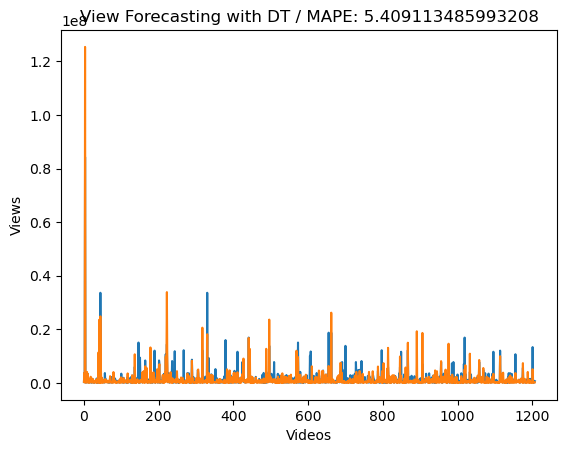

In [15]:
plt.plot(original_pred)
plt.plot(original_targets)
plt.title('View Forecasting with DT / MAPE: '+ str(mape))
plt.xlabel('Videos')
plt.ylabel('Views')
plt.show()

### Check Feature Importance

Die Implementierung des Decicion Trees der Sklearn Bibliothek ermöglicht es, die Feature Importance zu evaluieren. Dafür müssen die in mehrere Spalten aufgeteilten Features wieder kombiniert werden. 

In [16]:
# Create a DataFrame with Feature Importances
feature_importances = regressor.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

importance_df = importance_df.transpose()
importance_df.columns = importance_df.iloc[0]
importance_df = importance_df.drop('Feature')

# Sum encoded columns
column_list = ['tags_\d+','channel_title_\d+','description_\d+','title_\d+']

for i in column_list:

    filter_columns = importance_df.filter(regex=i)

    # Replace encoded columns with aggregated column
    importance_df = importance_df.drop(filter_columns, axis=1)
    importance_df[i[:-4]] = filter_columns.sum(axis=1)

# Clean importance_df for visualization
importance_df = importance_df.transpose()
importance_df = importance_df.reset_index()
importance_df = importance_df.sort_values('Importance', ascending=False)

importance_df

,Feature,Importance
2,description,0.912238
0,tags,0.059032
3,title,0.028404
1,channel_title,0.000327


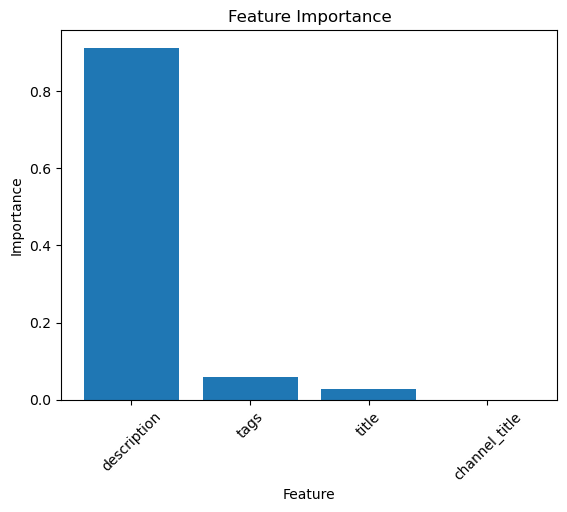

In [17]:
# Create plot of feature importances

plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()

In [19]:
# Save results for comparison

# Load the df
df = pd.read_csv('results_tra.csv')

# Add a new column
df['traditional'] = pred

# Save the modified df
df.to_csv('results_tra.csv', index=False)
